# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

from scipy import signal
from scipy.signal import butter, filtfilt

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data

In [3]:
base_path = "/content/drive/MyDrive/wearable_eeg/Data/"
all_users = []

# iterate over each user folder
for user_folder in os.listdir(base_path):
    user_path = os.path.join(base_path, user_folder)
    if not os.path.isdir(user_path):
        continue  # skip files if any

    user = user_folder  # e.g. "user1"

    # load trials
    trials = []
    for t in range(1, 4):
        trial_file = os.path.join(user_path, f"{user}-trial{t}.csv")
        if os.path.exists(trial_file):
            df = pd.read_csv(trial_file)
            df["user"] = user
            df["trial"] = f"trial{t}"
            trials.append(df)

    # load targets + answers
    targets_file = os.path.join(user_path, f"{user}-targets.csv")
    answers_file = os.path.join(user_path, f"{user}-answers.csv")

    targets = pd.read_csv(targets_file) if os.path.exists(targets_file) else None
    answers = pd.read_csv(answers_file) if os.path.exists(answers_file) else None

    all_users.append({
        "user": user,
        "trials": trials,
        "targets": targets,
        "answers": answers
    })


In [4]:
# example: user1's trial 2
user1_trials = all_users[0]["trials"]
print(user1_trials[1].shape)   # second trial dataframe

# targets and answers
print(all_users[0]["targets"].head())
print(all_users[0]["answers"].head())

(17820, 21)
   Targets
0        1
1        2
2        1
3        3
4        2
   Answers
0        1
1        2
2        1
3        3
4        2


# Combine all in one dataframe

In [5]:
all_trials = []
for u in all_users:
    all_trials.extend(u["trials"])  # add user’s 3 trials

df = pd.concat(all_trials, ignore_index=True)
print(df.shape)

(1548735, 21)


In [6]:
df

Time:128Hz   Epoch     Channel 1     Channel 2     Channel 3  \
0          0.000000     0.0  1.174495e+09  1.174405e+09  1.174045e+09   
1          0.007812     0.0  1.174489e+09  1.174395e+09  1.174022e+09   
2          0.015625     0.0  1.174501e+09  1.174406e+09  1.174077e+09   
3          0.023438     0.0  1.174506e+09  1.174412e+09  1.174129e+09   
4          0.031250     1.0  1.174524e+09  1.174417e+09  1.174147e+09   
...             ...     ...           ...           ...           ...   
1548730  124.023438  3968.0  1.174497e+09  1.174358e+09  1.174188e+09   
1548731  124.031250  3969.0  1.174501e+09  1.174309e+09  1.174137e+09   
1548732  124.039062  3969.0  1.174489e+09  1.174307e+09  1.174141e+09   
1548733  124.046875  3969.0  1.174497e+09  1.174307e+09  1.174159e+09   
1548734  124.054688  3969.0  1.174497e+09  1.174325e+09  1.174145e+09   

            Channel 4     Channel 5     Channel 6     Channel 7     Channel 8  \
0        1.174731e+09  1.174452e+09  1.175072e+09  1.174708e+09  1.174519e+09   
1        1.174719e+09  1.174458e+09  1.175071e+09  1.174707e+09  1.174490e+09   
2        1.174728e+09  1.174462e+09  1.175063e+09  1.174730e+09  1.174500e+09   
3        1.174737e+09  1.174446e+09  1.175045e+09  1.174724e+09  1.174519e+09   
4        1.174751e+09  1.174450e+09  1.175048e+09  1.174708e+09  1.174529e+09   
...               ...           ...           ...           ...           ...   
1548730  1.174840e+09  1.174480e+09  1.175065e+09  1.174742e+09  1.174552e+09   
1548731  1.174813e+09  1.174455e+09  1.175057e+09  1.174725e+09  1.174537e+09   
1548732  1.174821e+09  1.174437e+09  1.175050e+09  1.174715e+09  1.174532e+09   
1548733  1.174820e+09  1.174449e+09  1.175049e+09  1.174717e+09  1.174536e+09   
1548734  1.174806e+09  1.174472e+09  1.175064e+09  1.174730e+09  1.174552e+09   

         ...    Channel 10    Channel 11    Channel 12    Channel 13  \
0        ...  1.172609e+09  1.174841e+09  1.174419e+09  1.174462e+09   
1        ...  1.172550e+09  1.174824e+09  1.174417e+09  1.174435e+09   
2        ...  1.172599e+09  1.174834e+09  1.174426e+09  1.174446e+09   
3        ...  1.172619e+09  1.174851e+09  1.174444e+09  1.174487e+09   
4        ...  1.172617e+09  1.174863e+09  1.174450e+09  1.174510e+09   
...      ...           ...           ...           ...           ...   
1548730  ...  1.172574e+09  1.174761e+09  1.174418e+09  1.174451e+09   
1548731  ...  1.172523e+09  1.174737e+09  1.174387e+09  1.174440e+09   
1548732  ...  1.172533e+09  1.174729e+09  1.174389e+09  1.174439e+09   
1548733  ...  1.172550e+09  1.174730e+09  1.174418e+09  1.174436e+09   
1548734  ...  1.172574e+09  1.174753e+09  1.174420e+09  1.174439e+09   

           Channel 14  Event Id  Event Date  Event Duration    user   trial  
0        1.174086e+09       NaN         NaN             NaN   user1  trial1  
1        1.174077e+09       NaN         NaN             NaN   user1  trial1  
2        1.174104e+09       NaN         NaN             NaN   user1  trial1  
3        1.174131e+09       NaN         NaN             NaN   user1  trial1  
4        1.174155e+09       NaN         NaN             NaN   user1  trial1  
...               ...       ...         ...             ...     ...     ...  
1548730  1.174063e+09       NaN         NaN             NaN  user10  trial3  
1548731  1.174022e+09       NaN         NaN             NaN  user10  trial3  
1548732  1.174022e+09       NaN         NaN             NaN  user10  trial3  
1548733  1.174041e+09       NaN         NaN             NaN  user10  trial3  
1548734  1.174049e+09       NaN         NaN             NaN  user10  trial3  

[1548735 rows x 21 columns]

# Read the codes

In [7]:
events_map = pd.read_excel(base_path+'image_list.xlsx')
events_map

N° Imagen  Código                     Estímulo Imagen Clase
0           1   33025  OVTK_StimulationId_Label_01    A01     A
1           2   33026  OVTK_StimulationId_Label_02    A02     A
2           3   33027  OVTK_StimulationId_Label_03    A03     A
3           4   33028  OVTK_StimulationId_Label_04    A04     A
4           5   33029  OVTK_StimulationId_Label_05    A05     A
..        ...     ...                          ...    ...   ...
85         86   33110  OVTK_StimulationId_Label_56    T26     T
86         87   33111  OVTK_StimulationId_Label_57    T27     T
87         88   33112  OVTK_StimulationId_Label_58    T28     T
88         89   33113  OVTK_StimulationId_Label_59    T29     T
89         90   33114  OVTK_StimulationId_Label_5A    T30     T

[90 rows x 5 columns]

In [8]:
button_map = pd.read_excel('/content/drive/MyDrive/wearable_eeg/Data/button_list.xlsx')
button_map

N° tecla Código inicio Código final Nombre                    Clase
0         1         32786        32787   Left                        A
1         2         32788        32789  Right                        T
2         3         32790        32791   Down                        F
3         4         32792        32793  Enter                        -
4         5             -            -    Esc  Finaliza el experimento

In [9]:
stimulus_map = events_map.set_index("Código")["Clase"].to_dict()
response_map = button_map.set_index("Código inicio")["Nombre"].to_dict()
df["StimulusClass"] = df["Event Id"].map(stimulus_map)
df["UserResponse"] = df["Event Id"].map(response_map)

# Build response mapping

In [10]:
response_codes = {32786: "Left", 32788: "Right", 32790: "Down"}
stimulus_codes = set(stimulus_map.keys())  # from the Excel
len(stimulus_codes)

90

# Extract epochs

In [11]:
epochs = []
labels = []
reaction_times = []

pre = int(0.1 * 128)   # 0.1s baseline
post = int(2.9 * 128)  # 2.9s after
window_len = pre + post

for (user, trial), trial_df in df.groupby(["user", "trial"]):
    trial_df = trial_df.reset_index(drop=True)

    for idx, row in trial_df.iterrows():
        event_code = row["Event Id"]
        if event_code in stimulus_codes:
            start = idx - pre
            end = idx + post
            if start >= 0 and end < len(trial_df):
                # EEG segment
                epoch = trial_df.iloc[start:end, 2:16].values
                if epoch.shape[0] == window_len:
                    epochs.append(epoch)

                    # label = stimulus class
                    labels.append(stimulus_map.get(event_code, "Unknown"))

                    # reaction time = time until first valid response
                    rt = None
                    for j in range(idx+1, len(trial_df)):
                        resp_code = trial_df.loc[j, "Event Id"]
                        if resp_code in response_codes:
                            rt = (j - idx) / 128.0  # in seconds
                            break
                    reaction_times.append(rt)

In [12]:
X = np.array(epochs)   # (n_trials, 191, 14)
y = np.array(labels)   # (n_trials,)
RT = np.array(reaction_times)  # reaction times in seconds

In [13]:
X.shape

(900, 383, 14)

In [14]:
RT.shape

(900,)

In [15]:
y.shape

(900,)

# Mean per label, P300 and N400 highlighted (1s Raw EEG)

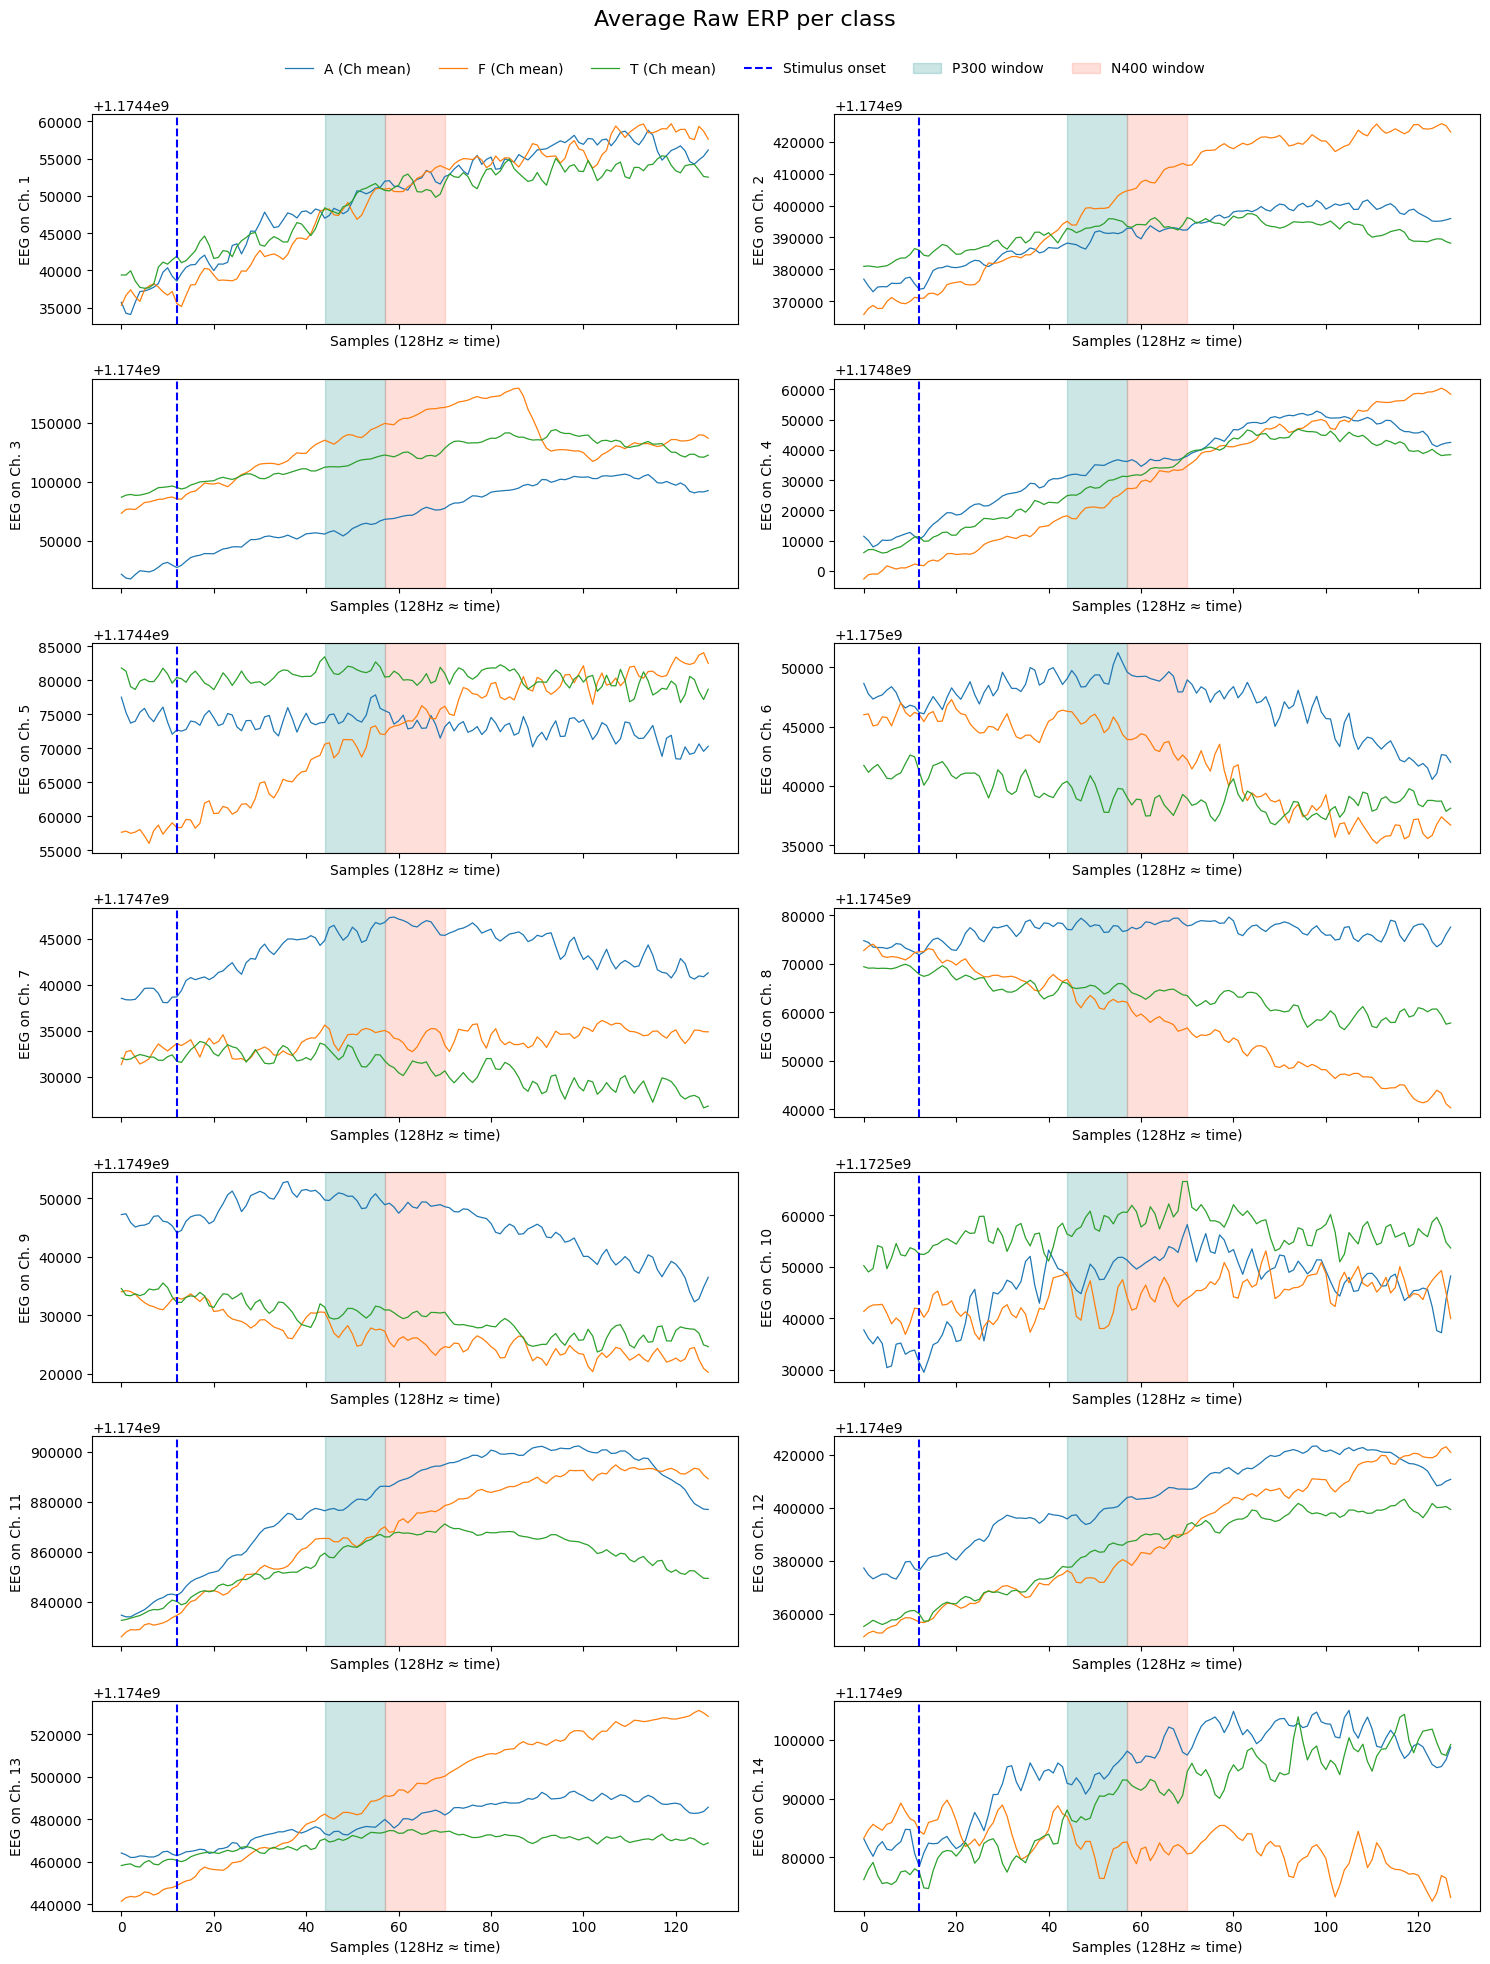

In [16]:
fig, axs = plt.subplots(7,2, figsize=(15,20), sharex=True, sharey=False, squeeze=False)
axs = axs.flat
for ch in range(14):
  for lbl in np.unique(y):
    class_epochs = X[:,:128][y == lbl]
    mean_epoch = class_epochs.mean(axis=0)  # (128*3, 14)

    axs[ch].plot(mean_epoch[:, ch], lw=0.9, label=f"{lbl} (Ch mean)")

  axs[ch].axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

  axs[ch].axvspan(pre+32, pre+45, color="teal", alpha=0.2, label="P300 window")
  axs[ch].axvspan(pre+45, pre+58, color="tomato", alpha=0.2, label="N400 window")

  axs[ch].set_ylabel("EEG on Ch. "+str(ch+1))
  axs[ch].set_xlabel("Samples (128Hz ≈ time)")


plt.suptitle("Average Raw ERP per class", fontsize=16)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.96),   # 0.5 = center, 1.02 = a bit above
    ncol=6,                       # columns, adjust to your labels
    frameon=False                  # cleaner look
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Epoch Visualization

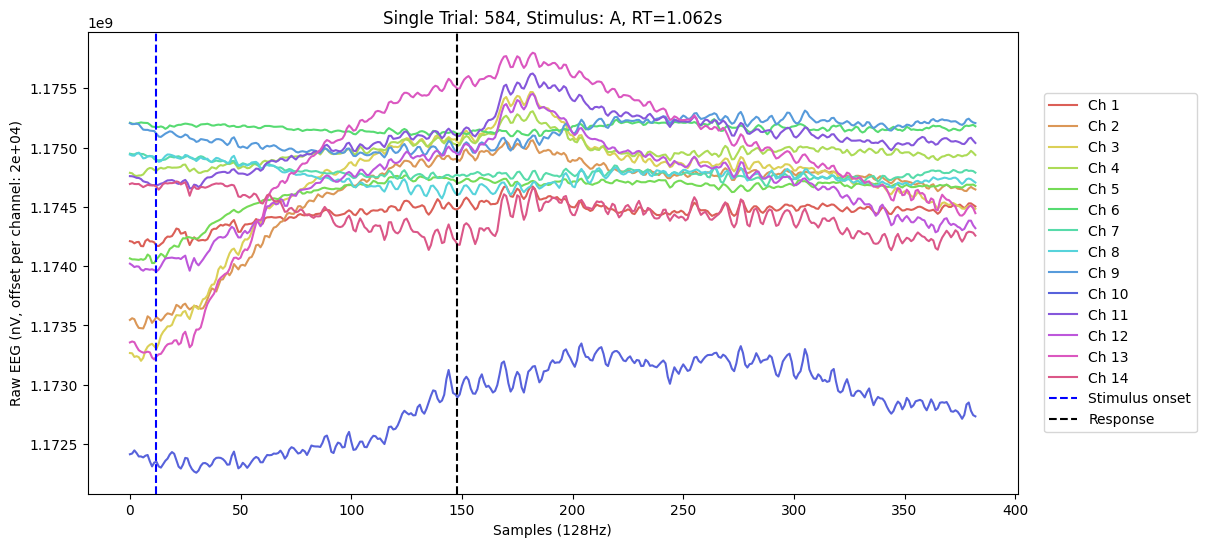

In [17]:
# ---- pick one trial (i, between 0 and 899) to inspect ---- #
# i = 0
i = randrange(900) # or generate a random integrer to see different results


offset = 2e4
epoch = X[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre (26)
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Raw EEG (nV, offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

# Normalization (per user)

In [18]:
n_trials_per_subj = 90
n_subj = 10
users = np.repeat(np.arange(n_subj), n_trials_per_subj)

X_norm = np.empty_like(X)

for subj in np.unique(users):
    subj_idx = (users == subj)
    subj_data = X[subj_idx]  # (n_trials_subj, channels, samples)

    # Mean/std per channel, computed across all trials & samples of subject
    mean = subj_data.mean(axis=(0, 2), keepdims=True)
    std = subj_data.std(axis=(0, 2), keepdims=True) + 1e-6  # avoid div 0

    X_norm[subj_idx] = (subj_data - mean) / std

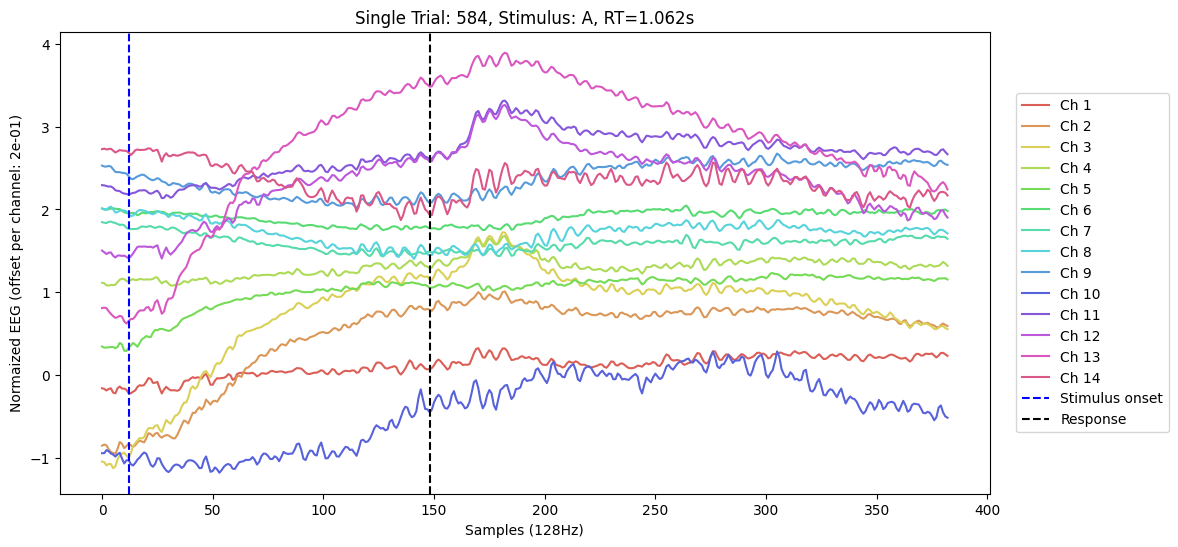

In [19]:
offset = 2e-1
epoch = X_norm[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre (26)
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Normaized EEG (offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

# Detrend (per trial)

## Linear detrend

In [20]:
# def detrend_whole_epochs_linear(X):
#     # X: (n_trials, n_samples, n_channels)
#     X_dt = signal.detrend(X, axis=1, type='linear')  # removes linear trend along time (axis=1) what'd happen if axis=2?
#     return X_dt
# X_whole_dt = detrend_whole_epochs_linear(X_bc)

In [21]:
def detrend_epochs_linear(trial):
    """
    trial: (n_samples, n_channels)
    Returns detrended trial, but keeps zeroed channels unchanged.
    """
    n_samples, n_channels = trial.shape
    trial_det = np.zeros_like(trial)

    # Mask bad channels (all zeros)
    bad_mask = np.all(trial == 0, axis=0)
    good_mask = ~bad_mask

    # Apply detrending only to good channels
    if np.any(good_mask):
        trial_det[:, good_mask] = signal.detrend(trial[:, good_mask], axis=0,
                                                 type="linear") # first degree polyn


    # Bad channels stay zero
    return trial_det

# Apply to all trials
X_det = np.array([detrend_epochs_linear(trial) for trial in X_norm])

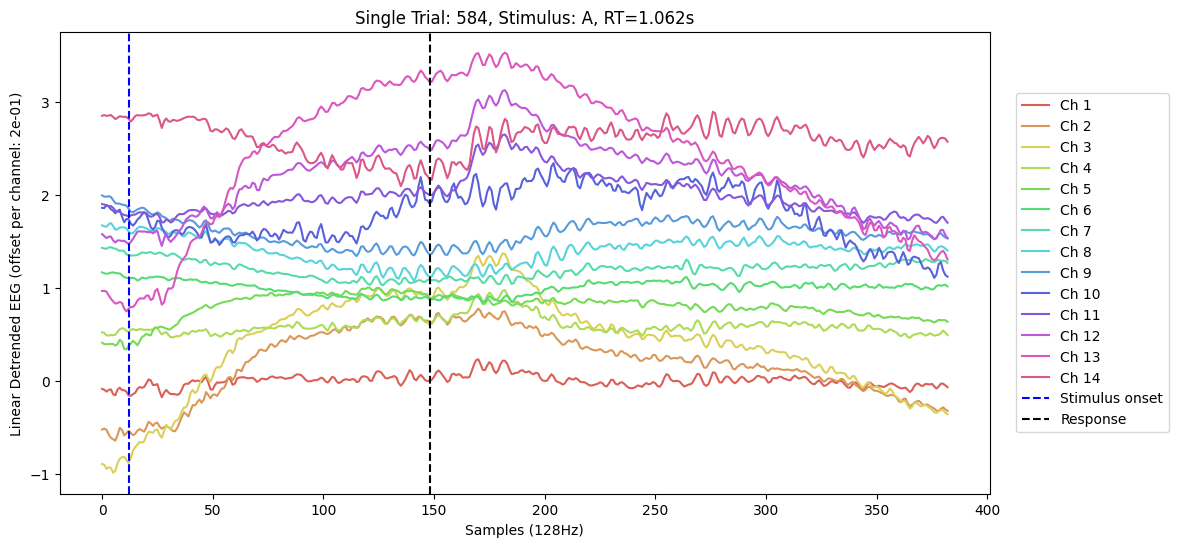

In [22]:
# offset = 2e-1
epoch = X_det[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre (26)
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Linear Detrended EEG (offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

## Poly detrend

In [23]:
def adaptive_poly_detrend(trial, max_order=2, return_orders=False):
    """
    Adaptive polynomial detrend per channel.

    trial: (n_samples, n_channels)
    max_order: highest polynomial degree to try
    return_orders: if True, also return the chosen order per channel

    Returns:
        trial_det: detrended trial (same shape as input)
        orders (optional): list of chosen polynomial order per channel
    """
    n_samples, n_channels = trial.shape
    trial_det = np.zeros_like(trial)
    orders = []

    t = np.arange(n_samples)

    for ch in range(n_channels):
        sig = trial[:, ch]

        # skip bad channels (all zeros)
        if np.all(sig == 0):
            trial_det[:, ch] = 0
            orders.append(0)
            continue

        best_order = 1
        best_mse = np.inf
        best_trend = np.zeros_like(sig)

        for order in range(1, max_order + 1):
            coeffs = np.polyfit(t, sig, order)
            trend = np.polyval(coeffs, t)

            mse = np.mean((sig - trend) ** 2)
            mse_penalized = mse * (1 + 0.1 * order)  # penalty for higher order

            if mse_penalized < best_mse:
                best_mse = mse_penalized
                best_order = order
                best_trend = trend

        trial_det[:, ch] = sig - best_trend
        orders.append(best_order)

    if return_orders:
        return trial_det, orders
    return trial_det

# Apply to all trials
X_poly_det = np.array([adaptive_poly_detrend(trial, max_order=10) for trial in X_norm])

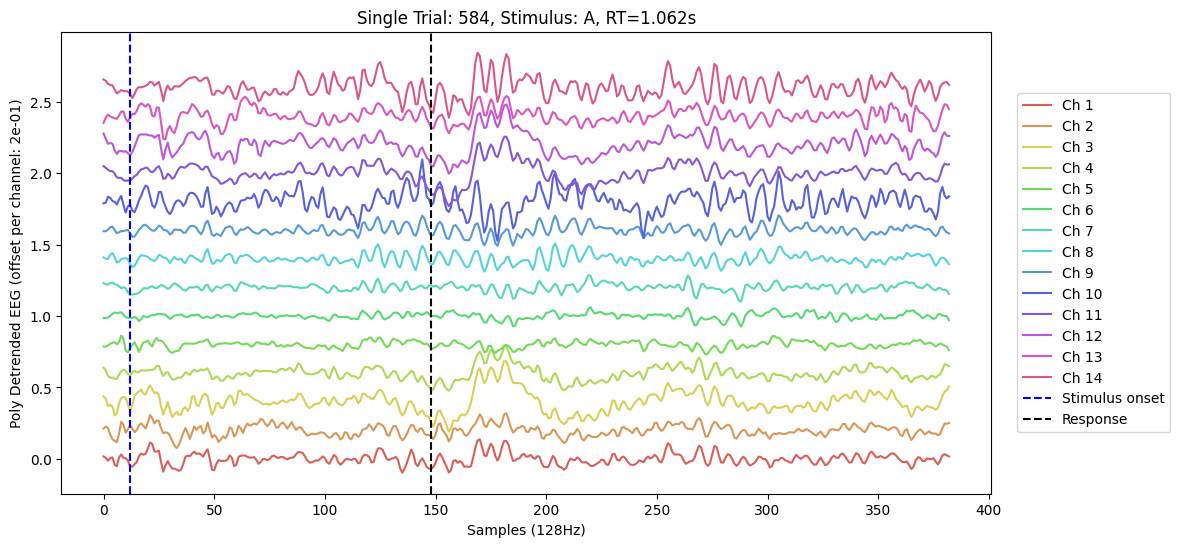

In [24]:
# offset = 2e-1
epoch = X_poly_det[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre (26)
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Poly Detrended EEG (offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

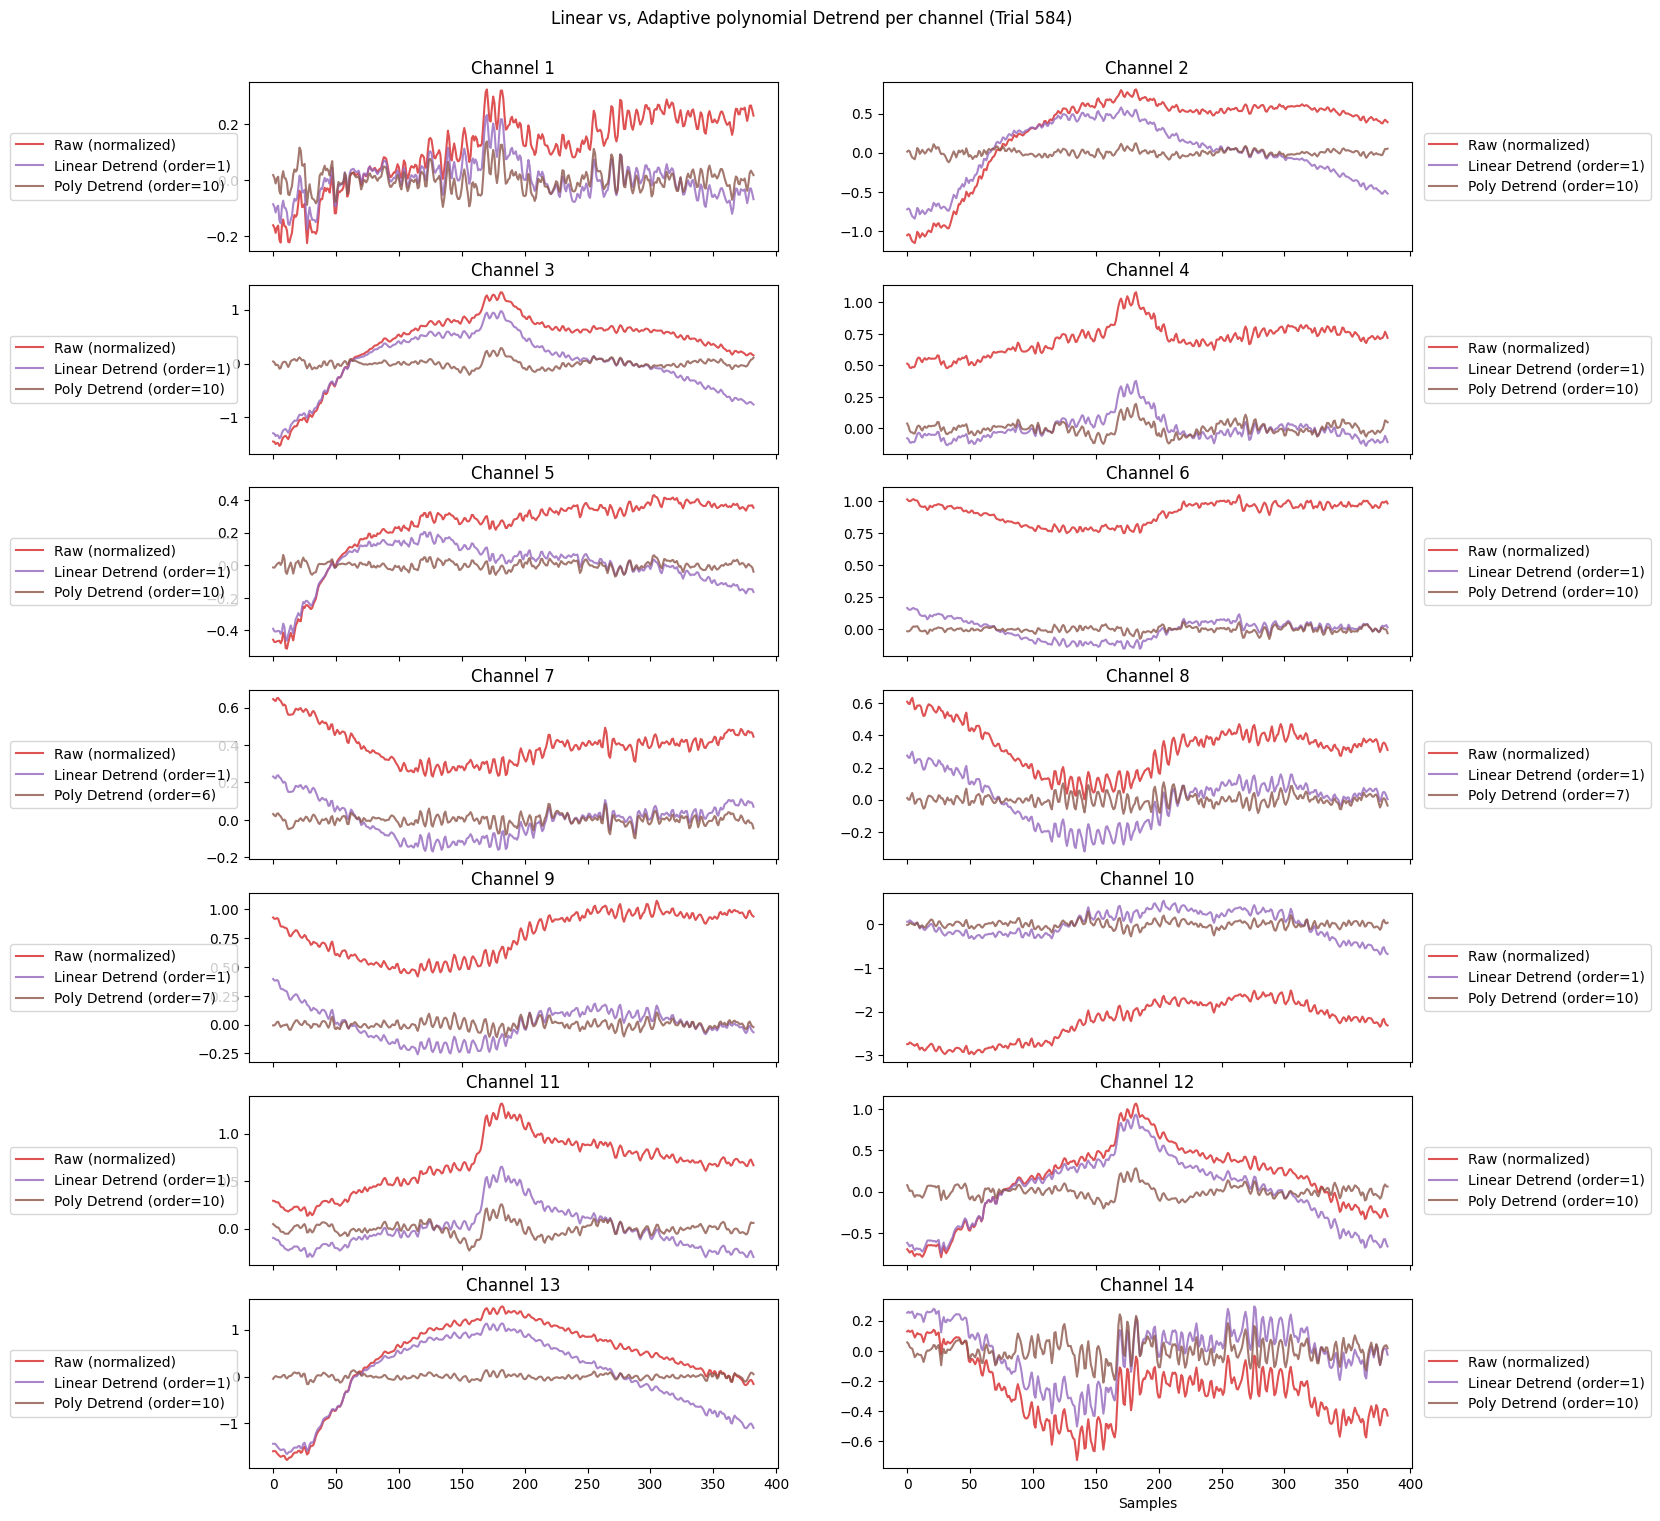

In [25]:
# --- Example: plot detrend for one trial ---
trial_idx = i
trial = X_norm[trial_idx]  # shape (n_samples, n_channels)

trial_det_poly, orders_poly = adaptive_poly_detrend(trial, max_order=10, return_orders=True)
trial_det = detrend_epochs_linear(trial)

fig, axs = plt.subplots(7, 2, figsize=(15, 18), sharex=True)
axs = axs.flatten()

t = np.arange(trial.shape[0])

for ch in range(trial.shape[1]):
    axs[ch].plot(t, trial[:, ch], alpha=0.8, label="Raw (normalized)",color='C03')
    axs[ch].plot(t, trial_det[:, ch], alpha=0.8, label="Linear Detrend (order=1)", color='C04')
    axs[ch].plot(t, trial_det_poly[:, ch], alpha=0.8, label=f"Poly Detrend (order={orders_poly[ch]})", color='C05')
    axs[ch].set_title(f"Channel {ch+1}")
    if ch%2==1: axs[ch].legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
    else: axs[ch].legend(loc='center right', bbox_to_anchor=(-0.01, 0.5))

plt.suptitle(f"Linear vs, Adaptive polynomial Detrend per channel (Trial {i})", y=0.92)
plt.xlabel("Samples")
plt.show()

# Filtering

In [26]:
def bandpass_filter(data, lowcut=0.1, highcut=30, fs=128, order=4):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0, padlen=min(20, data.shape[0]-1))

In [27]:
# We'll filter from X_norm
X_filt = np.array([bandpass_filter(trial, lowcut=0.9, highcut=45.0, fs=128) for trial in X_norm])

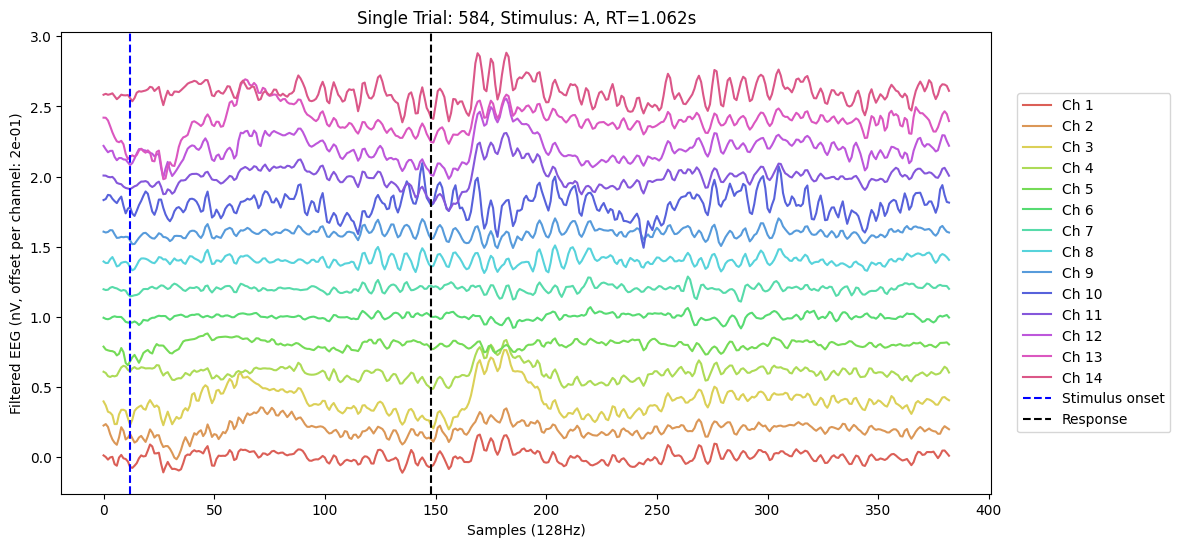

In [28]:
offset = 2e-1
epoch = X_filt[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Filtered EEG (nV, offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

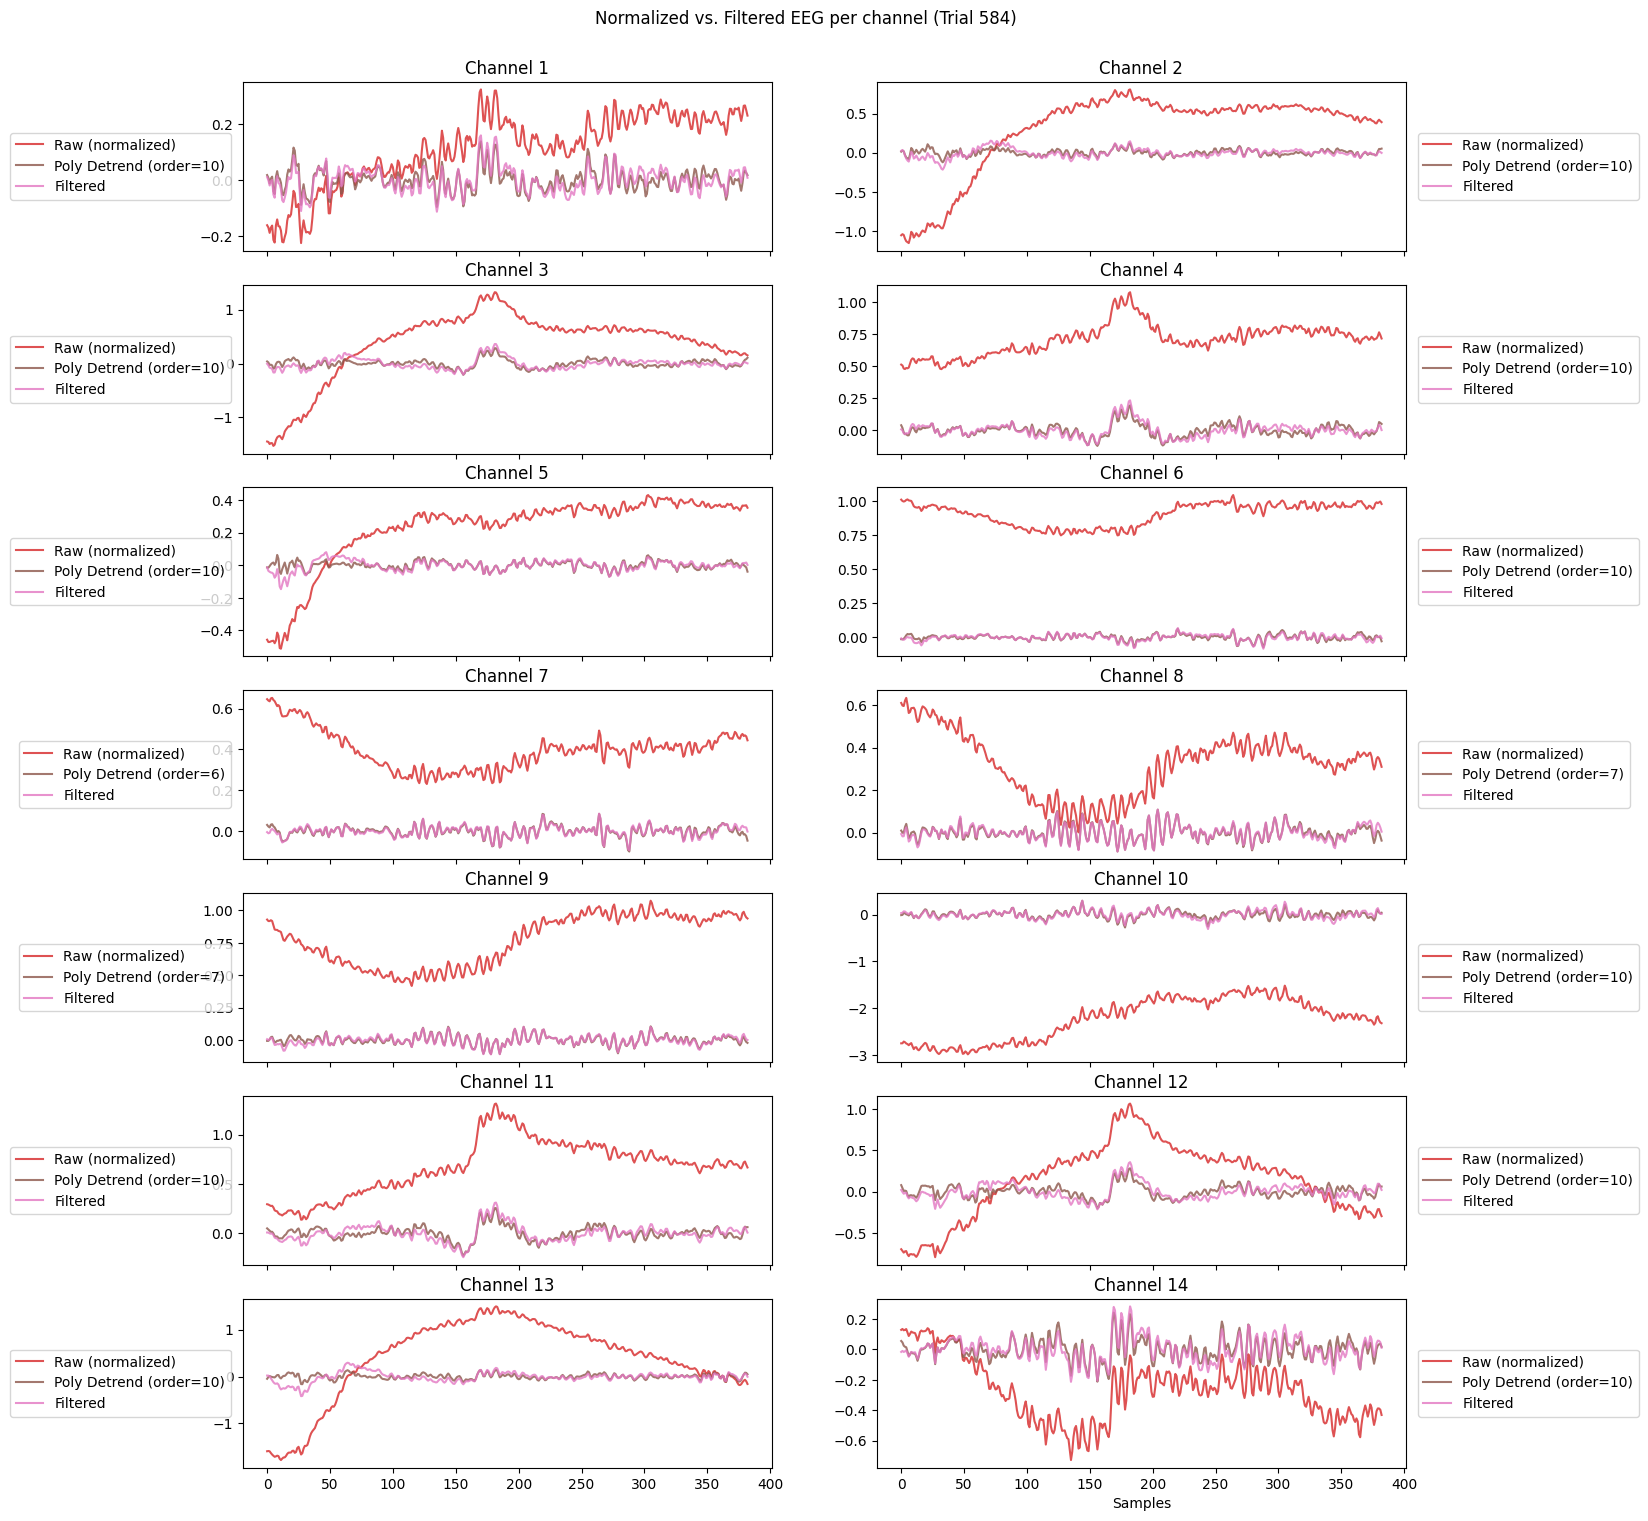

In [49]:
# --- Example: plot detrend for one trial ---
trial_idx = i
trial = X_norm[trial_idx]  # shape (n_samples, n_channels)
trial_filt = X_filt[trial_idx]
# trial_det = detrend_epochs_linear(trial)
trial_det_poly, orders_poly = adaptive_poly_detrend(trial, max_order=10, return_orders=True)

fig, axs = plt.subplots(7, 2, figsize=(15, 18), sharex=True)
axs = axs.flatten()

t = np.arange(trial.shape[0])

for ch in range(trial.shape[1]):
    axs[ch].plot(t, trial[:, ch], alpha=0.8, label="Raw (normalized)", color='C03')
    # axs[ch].plot(t, trial_det[:, ch], alpha=0.8, label="Linear Detrend (order=1)", color='C04')
    axs[ch].plot(t, trial_det_poly[:, ch], alpha=0.8, label=f"Poly Detrend (order={orders_poly[ch]})", color='C05')
    axs[ch].plot(t, trial_filt[:, ch], alpha=0.8, label="Filtered", color='C06')
    axs[ch].set_title(f"Channel {ch+1}")
    if ch%2==1: axs[ch].legend(loc='center left', bbox_to_anchor=(1.01, 0.5))
    else: axs[ch].legend(loc='center right', bbox_to_anchor=(-0.01, 0.5))

plt.suptitle(f"Normalized vs. Filtered EEG per channel (Trial {i})", y=0.92)
plt.xlabel("Samples")
plt.show()

# Baseline Correction (per channel)

In [30]:
fs = 128 # Hz
baseline_samples = int(0.1 * fs) # 0.1s baseline

X_bc = []
for trial in X_filt:
    baseline = trial[:baseline_samples, :].mean(axis=0)  # mean per channel
    trial_bc = trial - baseline
    X_bc.append(trial_bc)

X_bc = np.array(X_bc)

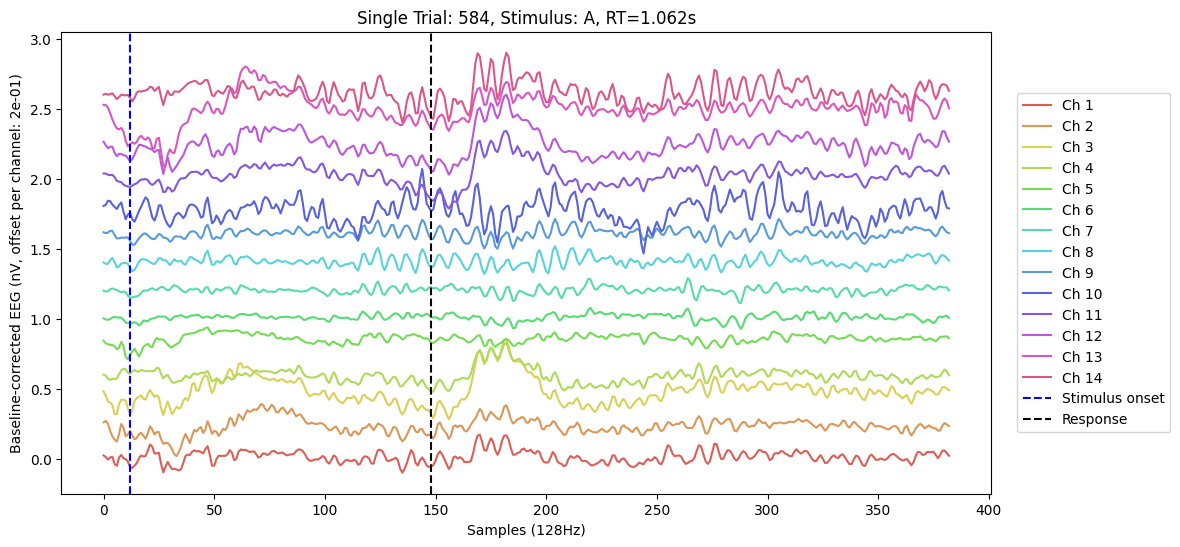

In [31]:
offset = 2e-1
epoch = X_bc[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre (26)
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Baseline-corrected EEG (nV, offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

# Channel selection

In [32]:
def compute_user_channel_mask(X_user, factor=3.0):
    """
    Compute a boolean mask of good channels for one user's data.

    X_user: (n_trials, n_times, n_channels)
    factor: multiplier for median variance threshold

    Returns: mask (n_channels,) where True = keep, False = bad
    """
    # Variance per channel across all trials+time
    variances = np.var(X_user, axis=(0, 1))  # shape: (n_channels,)
    threshold = np.median(variances) * factor
    good_channels = variances < threshold
    return good_channels


def apply_channel_mask(X_user, mask):
    """
    Zero out bad channels for all trials of a user.

    X_user: (n_trials, n_times, n_channels)
    mask: (n_channels,)
    """
    X_clean = X_user.copy()
    X_clean[:, :, ~mask] = 0
    return X_clean


X_clean_all = []
for user in range(10):
    idx = users == user
    X_user = X_bc[idx]   # (n_trials_user, n_times, n_channels)

    # Compute good channels for the whole user
    mask = compute_user_channel_mask(X_user, factor=3.0)

    # Apply mask
    X_user_clean = apply_channel_mask(X_user, mask)

    X_clean_all.append(X_user_clean)

# Reconstruct
X_clean = np.concatenate(X_clean_all, axis=0)
print(X_clean.shape)

(900, 383, 14)


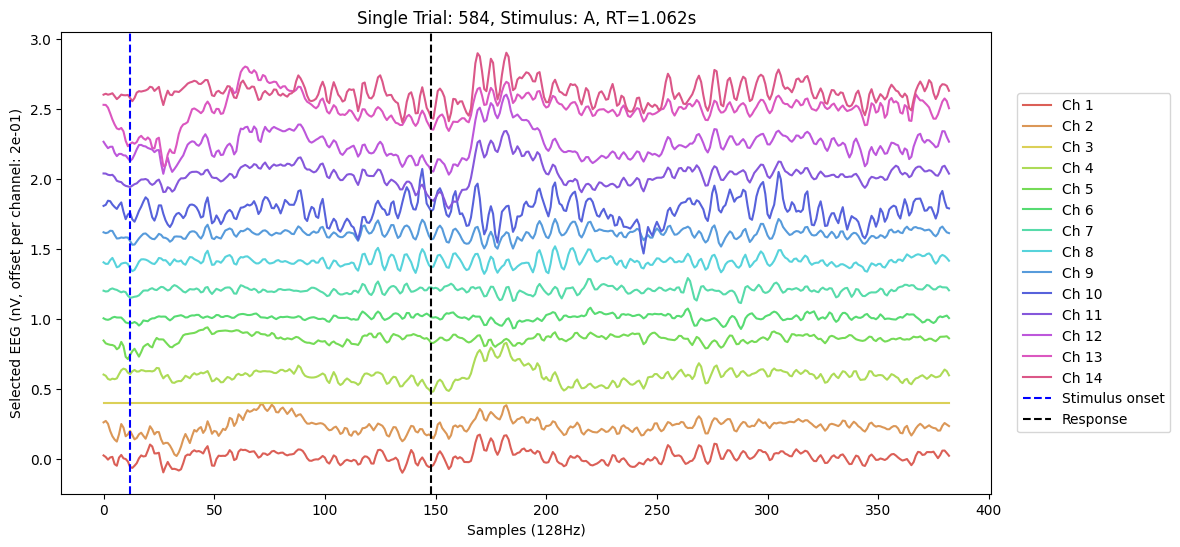

In [33]:
offset = 2e-1
epoch = X_clean[i]   # shape (3*128, 14)
label = y[i]
rt = RT[i]     # reaction time in seconds

# convert RT to sample index (relative to stimulus onset at sample=pre)
rt_sample = int(pre + rt * 128) if rt is not None else None

plt.figure(figsize=(12, 6))
color_list = sns.color_palette("hls", n_colors=14)
for ch in range(epoch.shape[1]):
    plt.plot(epoch[:, ch] + ch*offset, label=f"Ch {ch+1}", c=color_list[ch])  # offset per channel

# stimulus onset at sample=pre (26)
plt.axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

# response line if available
if rt_sample is not None and rt_sample < len(epoch):
    plt.axvline(x=rt_sample, color="black", linestyle="--", label="Response")

plt.title(f"Single Trial: {i}, Stimulus: {label}, RT={rt:.3f}s")
plt.xlabel("Samples (128Hz)")
plt.ylabel(f"Selected EEG (nV, offset per channel: {offset:.0e})")
plt.legend(loc="center right", bbox_to_anchor=(1.2, 0.5))
plt.show()

# Mean per label, P300 and N400 highlighted (1s Preprocessed EEG)

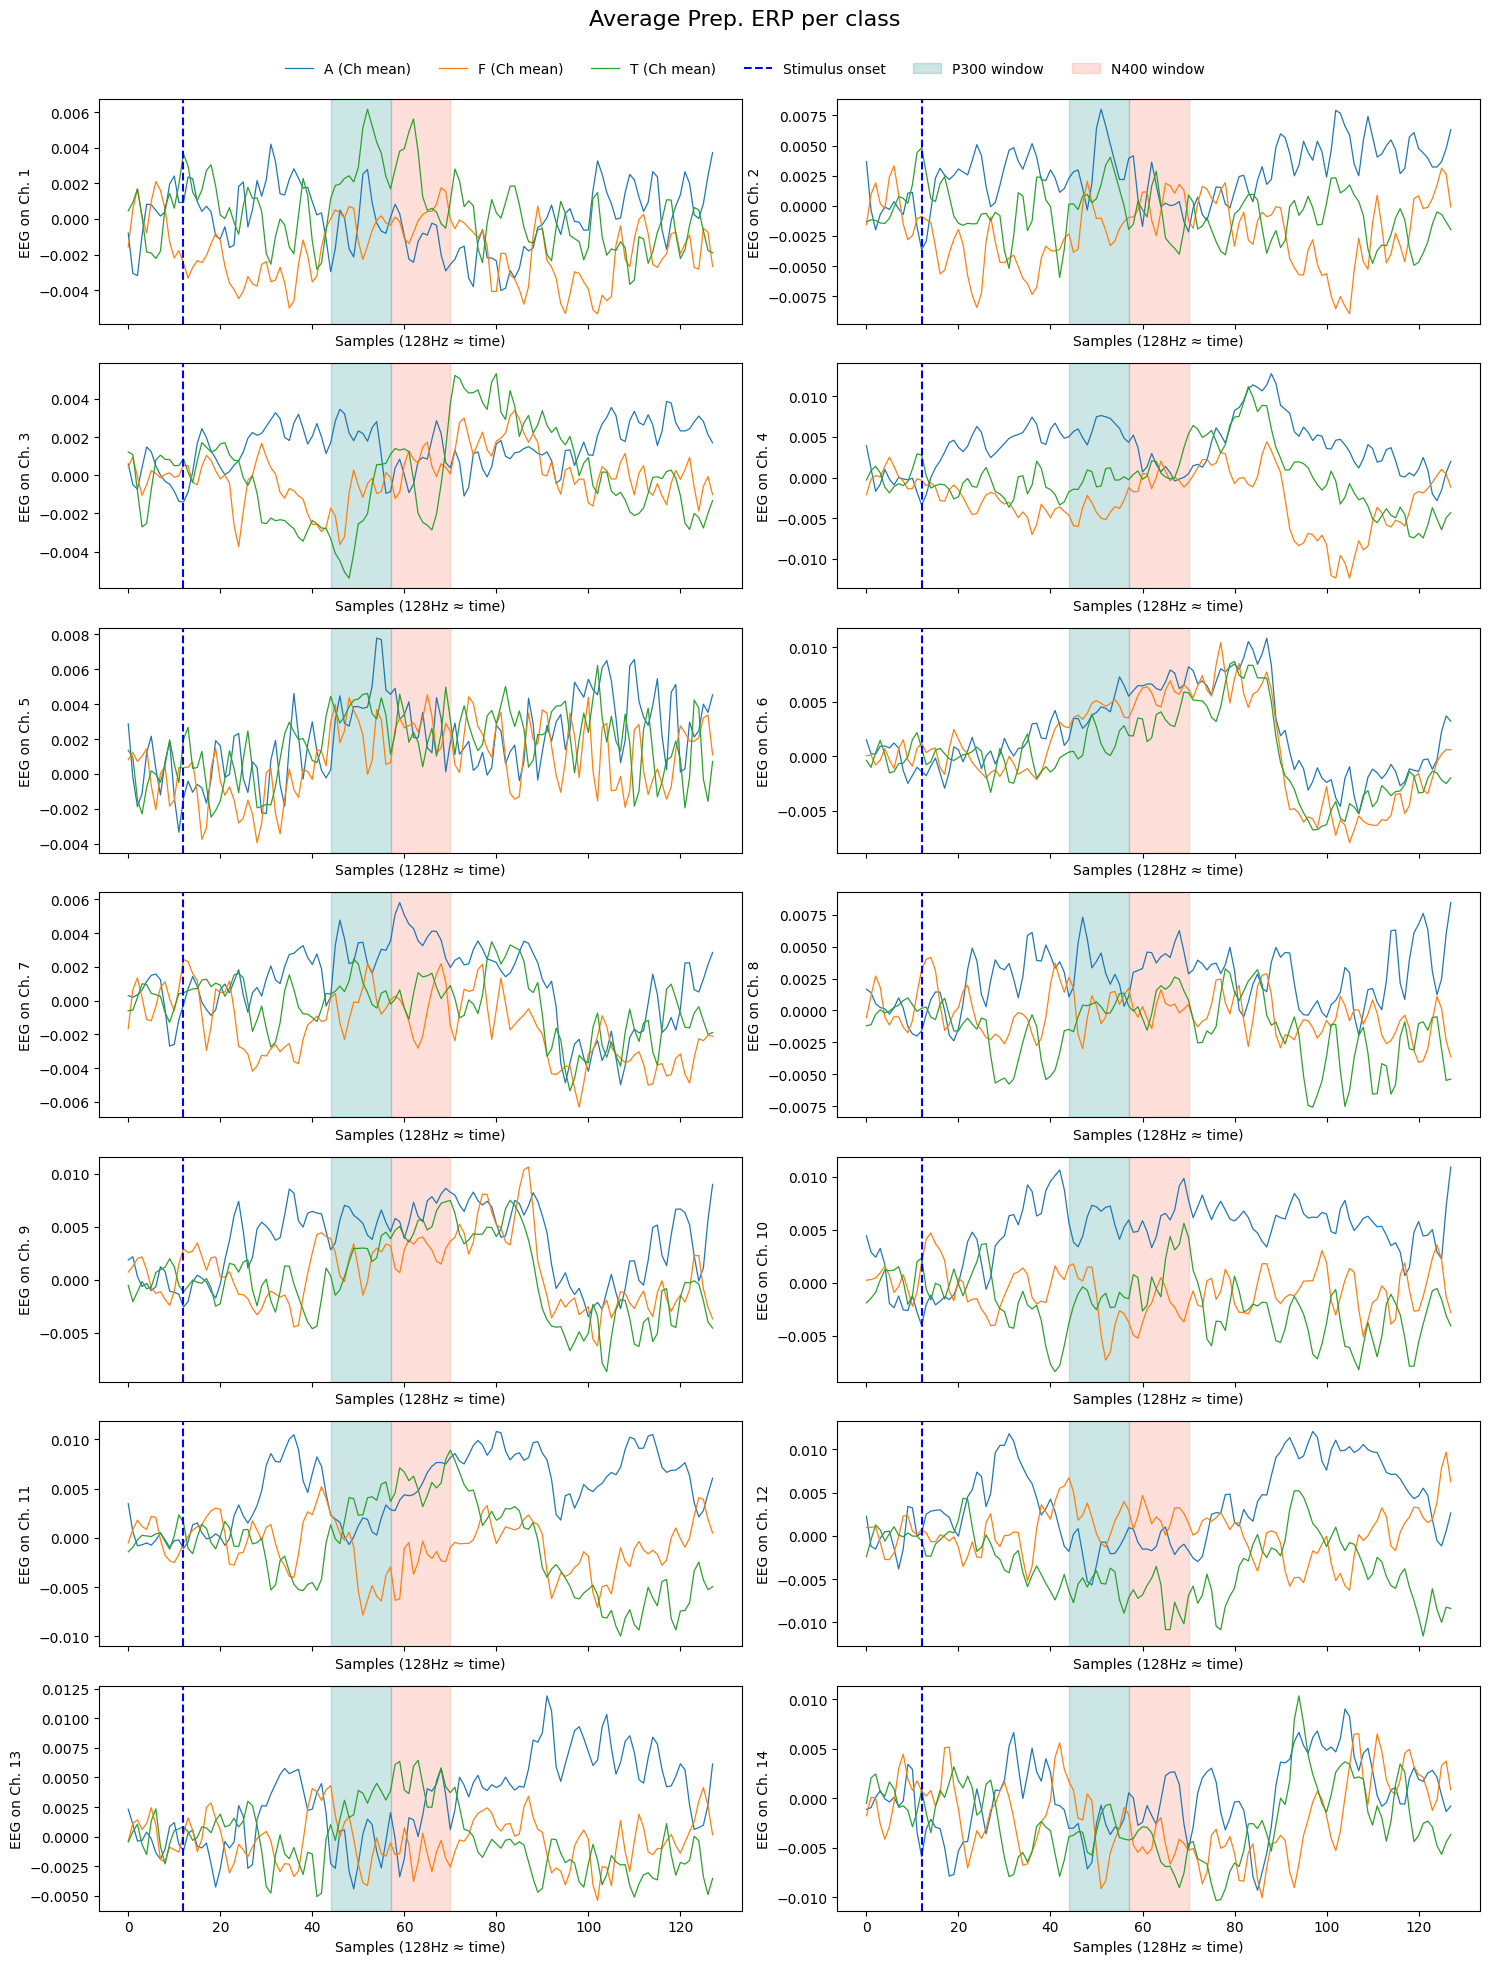

In [34]:
fig, axs = plt.subplots(7,2, figsize=(15,20), sharex=True, sharey=False, squeeze=False)
axs = axs.flat
for ch in range(14):
  for lbl in np.unique(y):
    class_epochs = X_clean[:,:128][y == lbl]
    mean_epoch = class_epochs.mean(axis=0)  # (128*3, 14)

    axs[ch].plot(mean_epoch[:, ch], lw=0.9, label=f"{lbl} (Ch mean)")

  axs[ch].axvline(x=pre, color="blue", linestyle="--", label="Stimulus onset")

  axs[ch].axvspan(pre+32, pre+45, color='teal', alpha=0.2, label="P300 window")
  axs[ch].axvspan(pre+45, pre+58, color='tomato', alpha=0.2, label="N400 window")

  axs[ch].set_ylabel("EEG on Ch. "+str(ch+1))
  axs[ch].set_xlabel("Samples (128Hz ≈ time)")


plt.suptitle("Average Prep. ERP per class", fontsize=16)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.96),   # 0.5 = center, 1.02 = a bit above
    ncol=6,                       # columns, adjust to your labels
    frameon=False                  # cleaner look
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Raw vs. Preprocessing comparison

/tmp/ipython-input-3811979104.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0" (-> color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)). The keyword argument will take precedence.
  axs[idx].plot(time, s, f"C{idx}", lw=1.2, color=cl)
/tmp/ipython-input-3811979104.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C1" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.
  axs[idx].plot(time, s, f"C{idx}", lw=1.2, color=cl)
/tmp/ipython-input-3811979104.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C2" (-> color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)). The keyword argument will take precedence.
  axs[idx].plot(time, s, f"C{idx}", lw=1.2, color=cl)
/tmp/ipython-input-3811979104.py:26: UserWarning: color is redundantly defined b

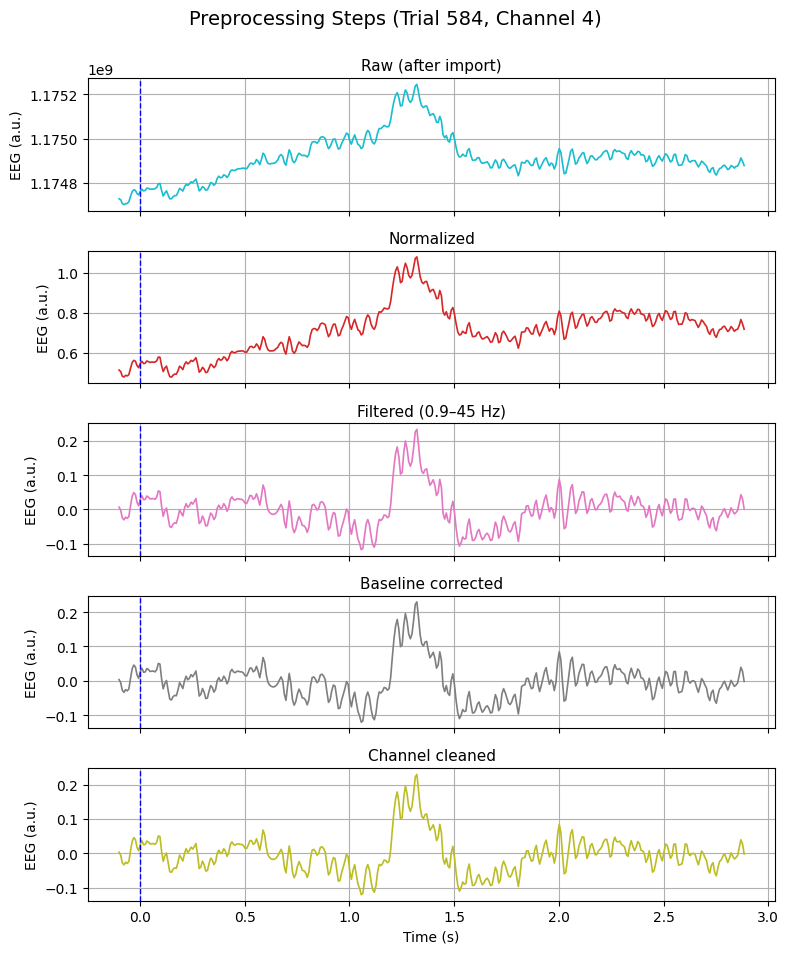

In [35]:
# Pick one trial and one channel
trial_idx, ch = i, 3
raw   = X[trial_idx, :, ch]
norm  = X_norm[trial_idx, :, ch]
filt  = X_filt[trial_idx, :, ch]
bc    = X_bc[trial_idx, :, ch]
# det   = X_poly_det[trial_idx, :, ch]
clean = X_clean[trial_idx, :, ch]

time = np.arange(len(raw)) / fs - 0.1  # seconds, baseline starts at -0.1

signals = [
    (raw,   "Raw (after import)", 'C09'),
    (norm,  "Normalized", 'C03'),
    # (det,   "Detrended"),
    (filt,  "Filtered (0.9–45 Hz)", 'C06'),
    (bc,    "Baseline corrected", 'C07'),
    (clean, "Channel cleaned", 'C08'),
]

# Create subplots
fig, axs = plt.subplots(len(signals), 1, figsize=(8, 10), sharex=True, sharey=False)
axs = axs.ravel()

for idx, (s, title, cl) in enumerate(signals):
    axs[idx].plot(time, s, f"C{idx}", lw=1.2, color=cl)
    axs[idx].axvline(0, color="blue", linestyle="--", lw=1)  # Stimulus onset
    axs[idx].set_title(title, fontsize=11)
    axs[idx].set_ylabel("EEG (a.u.)")
    axs[idx].grid()

# Common x-label
for ax in axs[-1:]:
    ax.set_xlabel("Time (s)")

# Suptitle closer to subplots
fig.suptitle(f"Preprocessing Steps (Trial {trial_idx}, Channel {ch+1})",
             fontsize=14, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Signal to Noise ratio

For EEG/ERP preprocessing comparisons, the signal to noise ratio (SNR) is the ratio of the power of a signal (meaningful input) to the power of background noise (meaningless input). So our approoach is:

1. Pick signal bands that carry task-related information, i.e. the EEG bands:

- delta: 0.5-4 Hz

- theta: 4-8 Hz

- alpha: 8-13 Hz

- beta: 13-30 Hz

- gamma: 30-45 Hz (if the sampling allows)

2. Define noise bands that represent unwanted energy:

- very low-frequency drift: 0-0.5 Hz (if present)

- high-frequency muscle / line noise: e.g., > 40 Hz (if recorded)

- or simply treat total power outside the interesting signal bands as noise.

3. Compute the SNR via:

- Band SNR (ratio), for a chosen band:
$$
SNR_{band} = \frac{P_{band}}{P_{noise}}
$$
- SNR in dB:
$$
SNR_{dB} = 10 \times log_{10} (SNR_{band})
$$

So, we'll compute band powers from Welch PSD and then compare raw vs preprocessed.

In [36]:
from scipy.signal import welch

# --- compute average PSD per channel (averaged across trials) ---
def mean_psd_over_trials(X, fs=128, nperseg=128):
    # X: (n_trials, n_samples, n_channels)
    n_trials, n_samples, n_channels = X.shape
    # We'll accumulate PSDs and freq vector once
    all_Pxx = None
    freqs = None
    for tr in range(n_trials):
        for ch in range(n_channels):
            f, Pxx = welch(X[tr, :, ch], fs=fs, nperseg=nperseg)
            if all_Pxx is None:
                freqs = f
                all_Pxx = np.zeros((n_trials, n_channels, len(f)))
            all_Pxx[tr, ch, :] = Pxx
    mean_Pxx = all_Pxx.mean(axis=0)  # (n_channels, len(f))
    return freqs, mean_Pxx

# --- bandpower extraction ---
def band_power_from_psd(f, Pxx, band):
    low, high = band
    idx = np.logical_and(f >= low, f <= high)
    if idx.sum() == 0:
        return 0.0
    # integrate PSD across band (trapezoidal)
    return np.trapezoid(Pxx[idx], f[idx])

def compute_band_powers_for_all_channels(f, P_channels, bands_dict):
    # P_channels: (n_channels, len(f))
    n_channels = P_channels.shape[0]
    out = {name: np.zeros(n_channels) for name in bands_dict}
    for ch in range(n_channels):
        Pxx = P_channels[ch, :]
        for name, band in bands_dict.items():
            out[name][ch] = band_power_from_psd(f, Pxx, band)
    return out

# compute noise power: sum over noise bands
def compute_noise_power(f, P_channels, noise_bands):
    n_channels = P_channels.shape[0]
    noise = np.zeros(n_channels)
    for nb in noise_bands.values():
        for ch in range(n_channels):
            noise[ch] += band_power_from_psd(f, P_channels[ch, :], nb)
    return noise

In [58]:
fs = 128  # sampling rate
nperseg = min(256, X.shape[1])  # or fs*2 but not larger than epoch length

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}

# Define noise band(s). Example: treat 0.0-0.5 Hz as drift noise and >45 Hz as HF noise (if available)
noise_bands = {
    "drift": (0.0, 0.5),
    "hf": (45, fs/2 - 1)
}

# Get PSD
f_raw, P_raw = mean_psd_over_trials(X, fs=fs, nperseg=nperseg)
f_prep, P_prep = mean_psd_over_trials(X_clean, fs=fs, nperseg=nperseg)

bandpowers_raw = compute_band_powers_for_all_channels(f_raw, P_raw, bands)
bandpowers_prep = compute_band_powers_for_all_channels(f_prep, P_prep, bands)

noise_raw = compute_noise_power(f_raw, P_raw, noise_bands)
noise_prep = compute_noise_power(f_prep, P_prep, noise_bands)

# --- compute SNR per band (ratio and dB) ---
snr_results = {}
for band in bands:
    signal_raw = bandpowers_raw[band]
    signal_prep = bandpowers_prep[band]
    # avoid divide by zero
    snr_raw = (signal_raw / (noise_raw + 1e-12))
    snr_prep = (signal_prep / (noise_prep + 1e-12))
    snr_results[band] = {
        "raw_ratio": snr_raw,
        "prep_ratio": snr_prep,
        "raw_db": 10 * np.log10(snr_raw + 1e-12),
        "prep_db": 10 * np.log10(snr_prep + 1e-12)
    }

# --- summary table (mean across channels) ---
rows = []
for band in bands:
    r_mean = np.nanmean(snr_results[band]["raw_ratio"])
    p_mean = np.nanmean(snr_results[band]["prep_ratio"])
    r_db = 10*np.log10(r_mean + 1e-12)
    p_db = 10*np.log10(p_mean + 1e-12)
    rows.append([band, r_mean, p_mean, r_db, p_db])
df_bands = pd.DataFrame(rows, columns=["band","raw_ratio_mean","prep_ratio_mean","raw_db_mean","prep_db_mean"])
df_bands

band  raw_ratio_mean  prep_ratio_mean  raw_db_mean  prep_db_mean
0  Delta        1.457211        36.738380     1.635224     15.651200
1  Theta        0.048716         7.689215   -13.123263      8.858820
2  Alpha        0.034518         5.699250   -14.619499      7.558177
3   Beta        0.097591        15.186071   -10.105916     11.814454
4  Gamma        0.028263         3.734058   -15.487887      5.721810

In [59]:
# --- summary table (mean across bands) ---
rows = []
for ch in range(14):
    r_mean = np.nanmean([snr_results[band]["raw_ratio"][ch] for band in bands])
    p_mean = np.nanmean([snr_results[band]["prep_ratio"][ch]for band in bands])
    r_db = 10*np.log10(r_mean + 1e-12)
    p_db = 10*np.log10(p_mean + 1e-12)
    rows.append([ch, r_mean, p_mean, r_db, p_db])
df_channels = pd.DataFrame(rows, columns=["channnel","raw_ratio_mean","prep_ratio_mean","raw_db_mean","prep_db_mean"])
df_channels

channnel  raw_ratio_mean  prep_ratio_mean  raw_db_mean  prep_db_mean
0          0        0.444767        16.623189    -3.518674     12.207143
1          1        0.261300         9.050631    -5.828598      9.566788
2          2        0.362761        13.726255    -4.403789     11.375521
3          3        0.349803        13.478598    -4.561766     11.296447
4          4        0.302146        10.532079    -5.197837     10.225141
5          5        0.303637        12.317218    -5.176458     10.905126
6          6        0.270086        12.450295    -5.684983     10.951797
7          7        0.308626        20.644716    -5.105670     13.148089
8          8        0.292341        14.819291    -5.341097     11.708274
9          9        0.354560        15.346555    -4.503099     11.860109
10        10        0.271138        14.971500    -5.668101     11.752653
11        11        0.389977        14.009310    -4.089609     11.464167
12        12        0.240903         7.426445    -6.181570      8.707809
13        13        0.513590        17.935442    -2.893833     12.537121

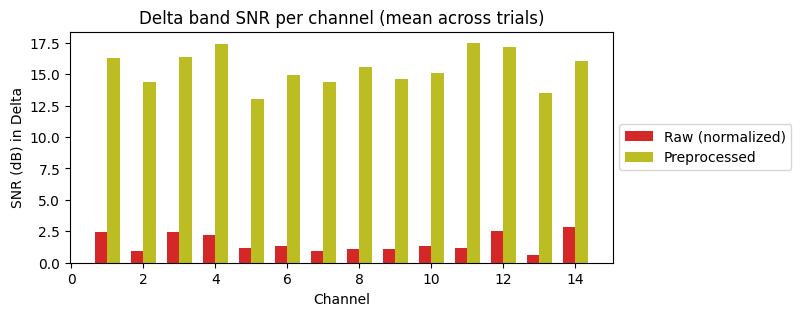

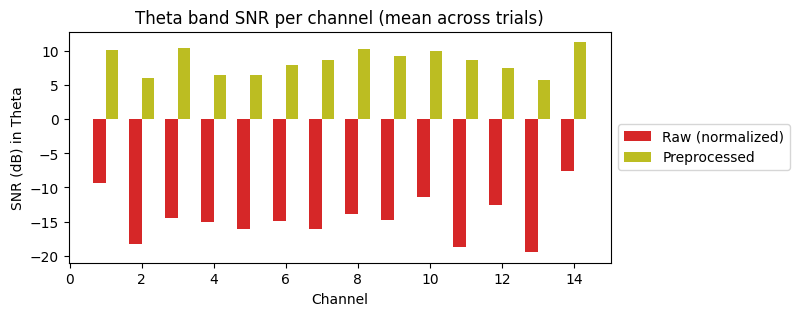

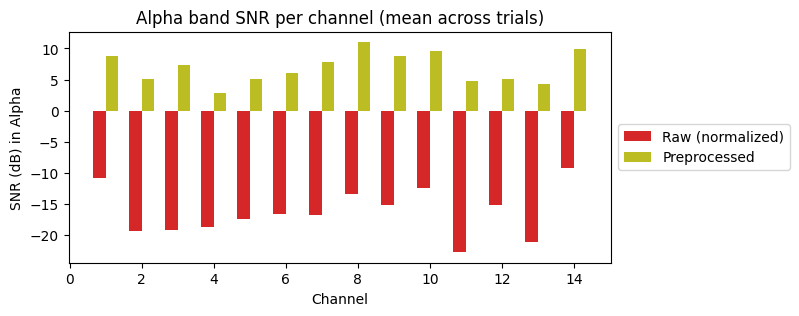

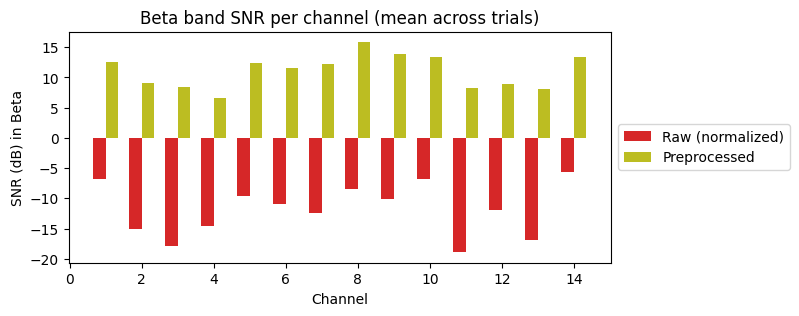

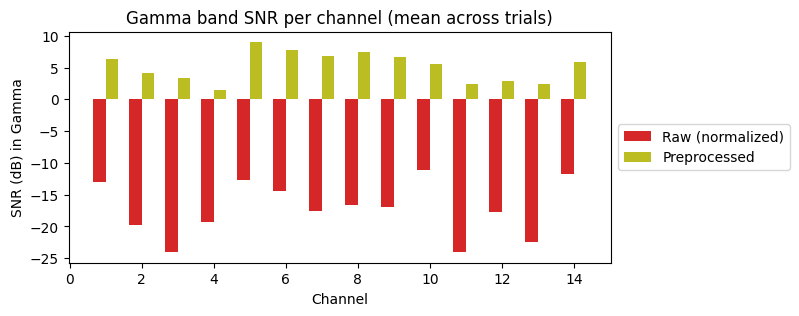

In [60]:
# Example: plot per-channel SNR in dB for alpha band
for band in df_bands.band:
    # band = "Delta"
    raw_db = snr_results[band]["raw_db"]
    prep_db = snr_results[band]["prep_db"]
    channels = np.arange(len(raw_db)) + 1

    plt.figure(figsize=(7,3))
    width = 0.35
    plt.bar(channels - width/2, raw_db, width, label="Raw (normalized)", color='C03')
    plt.bar(channels + width/2, prep_db, width, label="Preprocessed", color='C08')
    plt.xlabel("Channel")
    plt.ylabel("SNR (dB) in " + band)
    plt.title(f"{band} band SNR per channel (mean across trials)")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

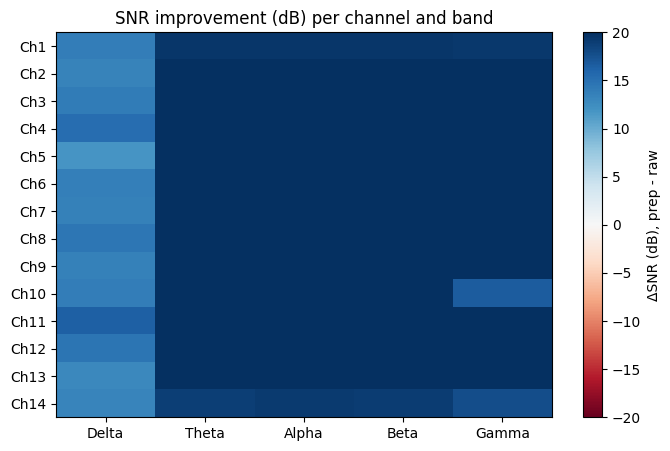

In [61]:
# Heatmap summary across bands (channels x bands) — prep - raw (dB improvement)
bands_list = list(bands.keys())
improvement = np.zeros((len(P_raw), len(bands_list)))
for bi, band in enumerate(bands_list):
    improvement[:, bi] = snr_results[band]["prep_db"] - snr_results[band]["raw_db"]

plt.figure(figsize=(8,5))
plt.imshow(improvement, aspect='auto', cmap='RdBu', vmin=-20, vmax=20)
plt.colorbar(label='ΔSNR (dB), prep - raw')
plt.yticks(np.arange(len(P_raw)), [f"Ch{ch+1}" for ch in range(len(P_raw))])
plt.xticks(np.arange(len(bands_list)), bands_list)
plt.title("SNR improvement (dB) per channel and band")
plt.show()

In [40]:
from scipy.signal import spectrogram
from matplotlib import colors

def plot_trial_spectrogram(X_raw, X_prep, trial_idx=0, ch=0, fs=128, nperseg=64, noverlap=32):
    """
    Plot spectrogram of one trial/channel before and after preprocessing.
    X_raw, X_prep: (n_trials, n_samples, n_channels)
    trial_idx: trial index to visualize
    ch: channel index
    fs: sampling rate
    """
    raw_signal = X_raw[trial_idx, :, ch]
    prep_signal = X_prep[trial_idx, :, ch]

    # Compute spectrograms
    f_raw, t_raw, Sxx_raw = spectrogram(raw_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    f_prep, t_prep, Sxx_prep = spectrogram(prep_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Convert to dB
    Sxx_raw_db = 10 * np.log10(Sxx_raw + 1e-12)
    Sxx_prep_db = 10 * np.log10(Sxx_prep + 1e-12)

    # create a single norm to be shared across the spectrograms
    norm = colors.Normalize(vmin=np.min([Sxx_raw_db,Sxx_prep_db]), vmax=np.max([Sxx_raw_db,Sxx_prep_db]))

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=False)

    im1 = axs[0].pcolormesh(t_raw, f_raw, Sxx_raw_db, cmap="viridis",
                            shading='gouraud',
                            norm=norm)
    axs[0].set_title(f"Normalized - Trial {trial_idx}, Ch {ch+1}")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Frequency (Hz)")
    fig.colorbar(im1, ax=axs[0], label="Power (dB)")

    im2 = axs[1].pcolormesh(t_prep, f_prep, Sxx_prep_db, cmap="viridis",
                            shading='gouraud',
                            norm=norm)
    axs[1].set_title(f"Preprocessed - Trial {trial_idx}, Ch {ch+1}")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Frequency (Hz)")
    fig.colorbar(im2, ax=axs[1], label="Power (dB)")

    plt.suptitle("Spectrogram Comparison (Normalized vs Preprocessed)", y=0.95)
    plt.tight_layout()
    plt.show()

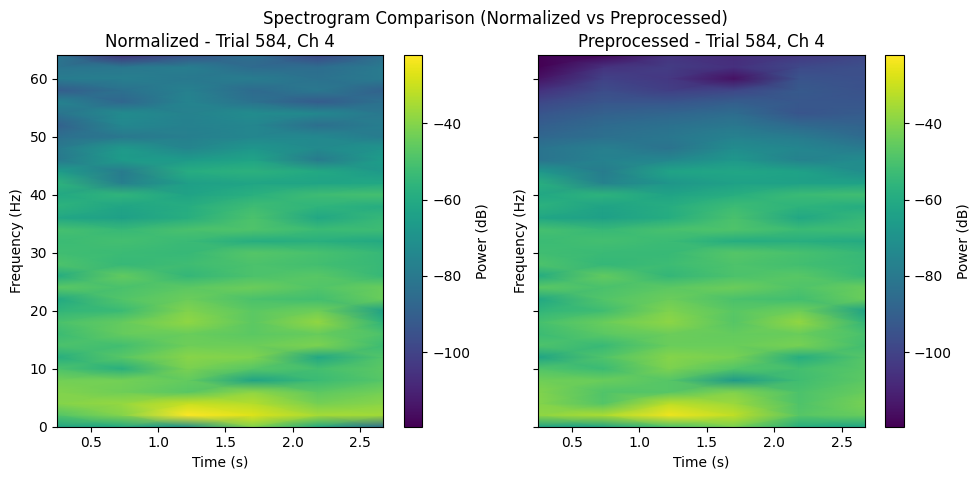

In [41]:
plot_trial_spectrogram(X_norm, X_clean, trial_idx=i, ch=3, fs=128, nperseg=64, noverlap=2)

In [42]:
def zoom_trial_spectrogram(X_raw, X_prep, trial_idx=0, ch=0, fs=128, nperseg=64, noverlap=32):
    raw_signal = X_raw[trial_idx, :, ch]
    prep_signal = X_prep[trial_idx, :, ch]

    # Compute spectrograms
    f_raw, t_raw, Sxx_raw = spectrogram(raw_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    f_prep, t_prep, Sxx_prep = spectrogram(prep_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Convert to dB
    Sxx_raw_db = 10 * np.log10(Sxx_raw + 1e-12)
    Sxx_prep_db = 10 * np.log10(Sxx_prep + 1e-12)

    # create a single norm to be shared across the spectrograms
    norm = colors.Normalize(vmin=np.min([Sxx_raw_db,Sxx_prep_db]), vmax=np.max([Sxx_raw_db,Sxx_prep_db]))

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=False)

    im1 = axs[0].pcolormesh(t_raw, f_raw[:16], Sxx_raw_db[:16,:], cmap="viridis",
                            shading='gouraud',
                            norm=norm)
    axs[0].set_title(f"Normalized - Trial {trial_idx}, Ch {ch+1}")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Frequency (Hz)")
    fig.colorbar(im1, ax=axs[0], label="Power (dB)")

    im2 = axs[1].pcolormesh(t_prep, f_prep[:16], Sxx_prep_db[:16,:], cmap="viridis",
                            shading='gouraud',
                            norm=norm)
    axs[1].set_title(f"Preprocessed - Trial {trial_idx}, Ch {ch+1}")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Frequency (Hz)")
    fig.colorbar(im2, ax=axs[1], label="Power (dB)")

    plt.suptitle("Zoom in - Spectrogram Comparison (Normalized vs Preprocessed)", y=0.95)
    plt.tight_layout()
    plt.show()

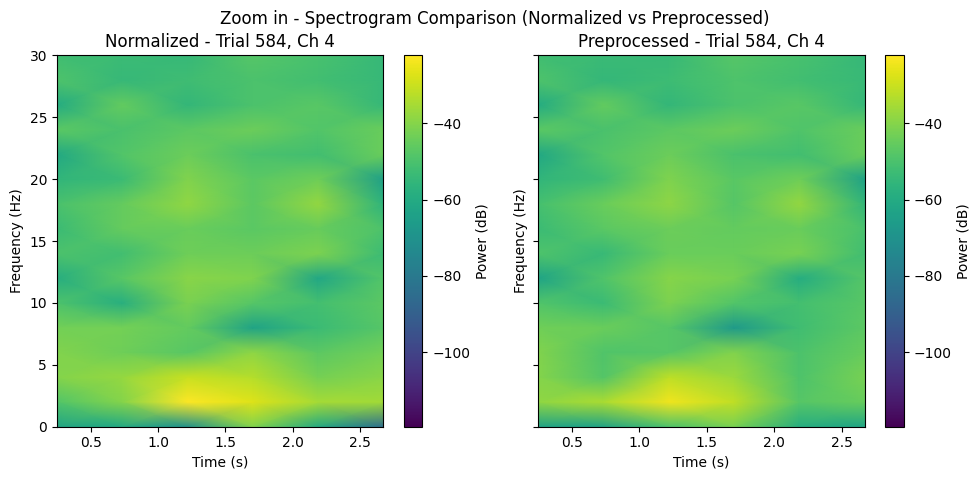

In [43]:
zoom_trial_spectrogram(X_norm, X_clean, trial_idx=i, ch=3, fs=128, nperseg=64, noverlap=2)

# Label encoding

In [44]:
# Animals = 0, Fruits = 1, Tools = 2
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Save RT, X and Y data

In [45]:
X_clean.shape

(900, 383, 14)

In [46]:
y.shape

(900,)

In [47]:
RT.shape

(900,)

In [48]:
# Flatten X into 2D if needed (e.g., (samples, features)) before saving
# X is (n_samples, n_times, n_channels): reshape into (n_samples, n_channels*n_times)
X_reshaped = X_clean.reshape(X_det.shape[0], -1)

# Save RT, X and y
pd.DataFrame(RT).to_csv(base_path+"RT.csv", index=False)
pd.DataFrame(X_reshaped).to_csv(base_path+"X.csv", index=False)
pd.DataFrame({"y": y_encoded}).to_csv(base_path+"y.csv", index=False)